# A Python Tour of Data Science: Data Acquisition & Exploration     

[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

In [1]:
# While packages are usually imported at the top, they can
# be imported wherever you prefer, in whatever scope.
import numpy as np

# Show matplotlib graphs inside the notebook.
%matplotlib inline

import sys
print('Python {}.{}'.format(sys.version_info.major, sys.version_info.minor))

Python 3.5


## 1 Data Importation

* The world is messy, we got data in CSV, [JSON](http://www.json.org), Excel, [HDF5](https://www.hdfgroup.org/HDF5) files and an SQL database.
* Could also have been matlab, HTML, XML files or from the web via scraping and APIs (e.g. [Twitter Firehose](https://dev.twitter.com/streaming/firehose)) or noSQL data stores, etc.

In [2]:
# Search modules in parent folder.
import sys
sys.path.append('..')
import utils

# Cross-platform (Windows / Mac / Linux) paths.
import os.path
folder = os.path.join('..', 'data', 'credit_card_defaults')

# Download the data.
utils.get_data(folder)

In [3]:
!ls ../data/credit_card_defaults/
# Windows: !dir ..\data\credit_card_defaults\

bills.hdf5  demographics.csv  payments.sqlite
delays.xls  original.xls      target.json


### 1.1 Importing from an SQL Database

[SQLAlchemy](http://www.sqlalchemy.org/) to the rescue.
* Abstraction between DBAPIs.
    * Supported databases: SQLite, Postgresql, MySQL, Oracle, MS-SQL, Firebird, Sybase and others.
* [SQL Expression Language](http://docs.sqlalchemy.org/en/rel_1_0/core/tutorial.html).
* [Object Relational Mapper (ORM)](http://docs.sqlalchemy.org/en/rel_1_0/orm/tutorial.html).

In [4]:
import sqlalchemy
filename = os.path.join(folder, 'payments.sqlite')
engine = sqlalchemy.create_engine('sqlite:///' + filename, echo=False)

# Infer from existing DB.
metadata = sqlalchemy.MetaData()
metadata.reflect(engine)

# An SQL SELECT statement.
table = metadata.tables.get('payments')
op = sqlalchemy.sql.select([table])
engine.echo = True
result = engine.execute(op)
engine.echo = False

2016-10-03 16:39:12,249 INFO sqlalchemy.engine.base.Engine SELECT payments."ID", payments."PAY1", payments."PAY2", payments."PAY3", payments."PAY4", payments."PAY5", payments."PAY6" 
FROM payments
2016-10-03 16:39:12,250 INFO sqlalchemy.engine.base.Engine ()


In [5]:
# Show some lines, i.e. clients.
for row in result.fetchmany(size=10):
    print('ID: {:2d}, payments: {}'.format(row[0], row[1:]))
result.close()

ID:  1, payments: (0, 689, 0, 0, 0, 0)
ID:  2, payments: (0, 1000, 1000, 1000, 0, 2000)
ID:  3, payments: (1518, 1500, 1000, 1000, 1000, 5000)
ID:  4, payments: (2000, 2019, 1200, 1100, 1069, 1000)
ID:  5, payments: (2000, 36681, 10000, 9000, 689, 679)
ID:  6, payments: (2500, 1815, 657, 1000, 1000, 800)
ID:  7, payments: (55000, 40000, 38000, 20239, 13750, 13770)
ID:  8, payments: (380, 601, 0, 581, 1687, 1542)
ID:  9, payments: (3329, 0, 432, 1000, 1000, 1000)
ID: 10, payments: (0, 0, 0, 13007, 1122, 0)


In [6]:
# Execute some raw SQL.
paid = 1000
op = sqlalchemy.sql.text('SELECT payments."ID", payments."PAY6" FROM payments WHERE payments."PAY6" = {}'.format(paid))
result = engine.execute(op).fetchall()
print('{} clients paid {} in April 2005'.format(len(result), paid))

1299 clients paid 1000 in April 2005


### 1.2 Merging data Sources

Put some [pandas](http://pandas.pydata.org/) in our Python !
* Import / export data from / to various sources.
* Data frames manipulations: slicing, dicing, grouping.
* And many more !

In [7]:
def get_data(directory):
    filename_csv = os.path.join(directory, 'demographics.csv')
    filename_xls = os.path.join(directory, 'delays.xls')
    filename_hdf = os.path.join(directory, 'bills.hdf5')
    filename_json = os.path.join(directory, 'target.json')

    demographics = pd.read_csv(filename_csv, index_col=0)
    delays = pd.read_excel(filename_xls, index_col=0)
    bills = pd.read_hdf(filename_hdf, 'bills')
    payments = pd.read_sql('payments', engine, index_col='ID')
    target = pd.read_json(filename_json)

    return pd.concat([demographics, delays, bills, payments, target], axis=1)

import pandas as pd
data = get_data(folder)
attributes = data.columns.tolist()

# Tansform from numerical to categorical variable.
data['SEX'] = data['SEX'].astype('category')
data['SEX'].cat.categories = ['MALE', 'FEMALE']
data['MARRIAGE'] = data['MARRIAGE'].astype('category')
data['MARRIAGE'].cat.categories = ['UNK', 'MARRIED', 'SINGLE', 'OTHERS']
data['EDUCATION'] = data['EDUCATION'].astype('category')
data['EDUCATION'].cat.categories = ['UNK', 'GRAD SCHOOL', 'UNIVERSITY', 'HIGH SCHOOL', 'OTHERS', 'UNK1', 'UNK2']

### 1.3 Looking at the Data

In [8]:
data.loc[:6, ['LIMIT', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'DEFAULT']]

,LIMIT,SEX,EDUCATION,MARRIAGE,AGE,DEFAULT
ID,,,,,,
1,20000,FEMALE,UNIVERSITY,MARRIED,24,1
2,120000,FEMALE,UNIVERSITY,SINGLE,26,1
3,90000,FEMALE,UNIVERSITY,SINGLE,34,0
4,50000,FEMALE,UNIVERSITY,MARRIED,37,0
5,50000,MALE,UNIVERSITY,MARRIED,57,0
6,50000,MALE,GRAD SCHOOL,SINGLE,37,0


In [9]:
data.iloc[:5, 4:10]

,AGE,DELAY1,DELAY2,DELAY3,DELAY4,DELAY5
ID,,,,,,
1,24,2,2,-1,-1,-2
2,26,-1,2,0,0,0
3,34,0,0,0,0,0
4,37,0,0,0,0,0
5,57,-1,0,-1,0,0


In [10]:
data.iloc[:5, 11:23]

,BILL1,BILL2,BILL3,BILL4,BILL5,BILL6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6
ID,,,,,,,,,,,,
1,3913,3102,689,0,0,0,0,689,0,0,0,0
2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


Export as an [HTML table](./subset.html) for manual inspection.

In [11]:
data[:1000].to_html('subset.html')

## 2 Data Cleaning

While cleaning data is the [most time-consuming, least enjoyable Data Science task](http://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says), it should be perfomed nonetheless. Problems come in two flavours:

1. Missing data, i.e. unknown values.
1. Errors in data, i.e. wrong values.

The actions to be taken in each case is highly **data and problem specific**.

Example: marital status
1. According to dataset description, it should either be 1 (married), 2 (single) or 3 (others).
1. But we find some 0 (previously transformed to `UNK`).
1. Let's *assume* that 0 represents errors when collecting the data and that we should remove those clients.

In [12]:
print(data['MARRIAGE'].value_counts())
data = data[data['MARRIAGE'] != 'UNK']
data['MARRIAGE'] = data['MARRIAGE'].cat.remove_unused_categories()
print('\nWe are left with {} clients\n'.format(data.shape))
print(data['MARRIAGE'].unique())

SINGLE     15964
MARRIED    13659
OTHERS       323
UNK           54
Name: MARRIAGE, dtype: int64

We are left with (29946, 24) clients

[MARRIED, SINGLE, OTHERS]
Categories (3, object): [MARRIED, SINGLE, OTHERS]


Example: education
1. It should either be 1 (graduate school), 2 (university), 3 (high school) or 4 (others).
1. But we find some 0, 5 and 6 (previously transformed to `UNK`, `UNK1` and `UNK2`).
1. Let's *assume* these values are dubious, but do not invalidate the data and keep them as they may have some predictive power.

In [13]:
print(data['EDUCATION'].value_counts())
data.loc[data['EDUCATION']=='UNK1', 'EDUCATION'] = 'UNK'
data.loc[data['EDUCATION']=='UNK2', 'EDUCATION'] = 'UNK'
data['EDUCATION'] = data['EDUCATION'].cat.remove_unused_categories()
print(data['EDUCATION'].value_counts())

UNIVERSITY     14024
GRAD SCHOOL    10581
HIGH SCHOOL     4873
UNK1             280
OTHERS           123
UNK2              51
UNK               14
Name: EDUCATION, dtype: int64
UNIVERSITY     14024
GRAD SCHOOL    10581
HIGH SCHOOL     4873
UNK              345
OTHERS           123
Name: EDUCATION, dtype: int64


## 3 Data Exploration

* Get descriptive statistics.
* Plot informative figures.
* Verify some intuitive correlations.

Let's get first some descriptive statistics of our numerical variables.

In [14]:
attributes_numerical = ['LIMIT', 'AGE']
attributes_numerical.extend(attributes[11:23])
data.loc[:, attributes_numerical].describe().astype(np.int)

,LIMIT,AGE,BILL1,BILL2,BILL3,BILL4,BILL5,BILL6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6
count,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946,29946
mean,167546,35,51278,49224,47063,43306,40352,38911,5659,5926,5227,4829,4804,5220
std,129807,9,73682,71219,69393,64374,60836,59592,16552,23060,17618,15677,15290,17791
min,10000,21,-165580,-69777,-157264,-170000,-81334,-339603,0,0,0,0,0,0
25%,50000,28,3570,2988,2684,2335,1770,1261,1000,836,390,298,255,122
50%,140000,34,22400,21221,20108,19066,18121,17098,2100,2010,1800,1500,1500,1500
75%,240000,41,67263,64108,60240,54601,50244,49248,5007,5000,4511,4015,4040,4000
max,1000000,79,964511,983931,1664089,891586,927171,961664,873552,1684259,896040,621000,426529,528666


Let's plot an histogram of the ages, so that we get a better impression of who our clients are. That may even be an end goal, e.g. if your marketing team asks which customer groups to target.

Then a boxplot of the bills, which may serve as a verification of the quality of the acquired data.

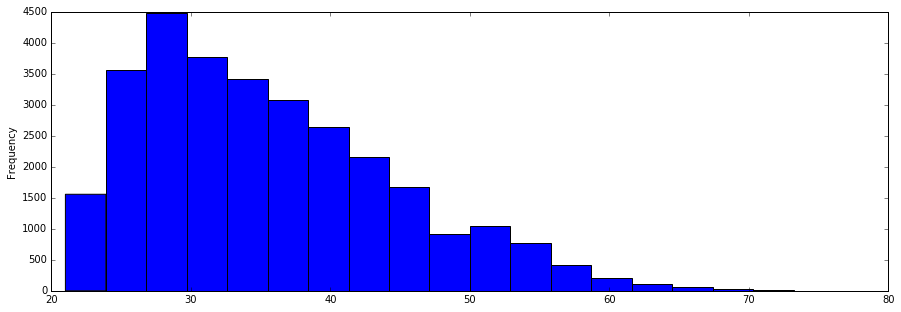

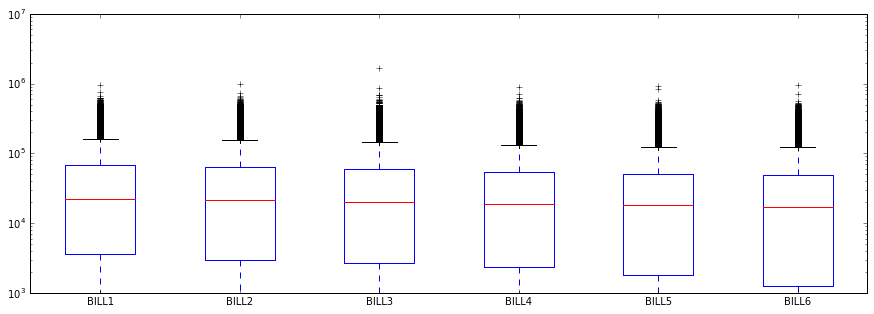

In [15]:
data.loc[:, 'AGE'].plot.hist(bins=20, figsize=(15,5))
ax = data.iloc[:, 11:17].plot.box(logy=True, figsize=(15,5))

Simple **question**: which proportion of our clients default ?

In [16]:
percentage = data['DEFAULT'].value_counts()[1] / data.shape[0] * 100
print('Percentage of defaults: {:.2f}%'.format(percentage))

Percentage of defaults: 22.14%


Another **question**: who's more susceptible to default, males or females ?

In [17]:
observed = pd.crosstab(data['SEX'], data['DEFAULT'], margins=True)
observed

DEFAULT,0,1,All
SEX,,,
MALE,9003,2871,11874
FEMALE,14312,3760,18072
All,23315,6631,29946


Seems like females are better risk. Let's verify with a Chi-Squared test of independance, using [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html).

In [18]:
import scipy.stats as stats
_, p, _, expected = stats.chi2_contingency(observed.iloc[:2,:2])
print('p-value = {:.2e}'.format(p))
print('expected values:\n{}'.format(expected))

p-value = 6.75e-12
expected values:
[[  9244.71749148   2629.28250852]
 [ 14070.28250852   4001.71749148]]


**Intuition**: people who pay late present a higher risk of defaulting. Let's verify !
Verifying some intuitions will also help you to identify mistakes. E.g. it would be suspicious if that intuition is not verified in the data: did we select the right column, or did we miss-compute a result ?

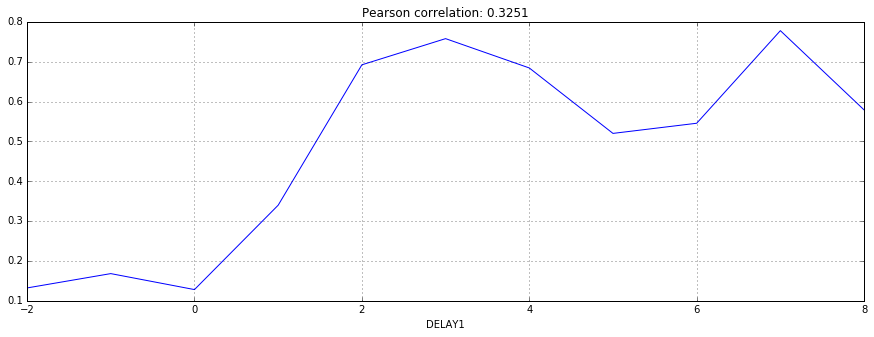

In [19]:
group = data.groupby('DELAY1').mean()
corr = data['DEFAULT'].corr(data['DELAY1'], method='pearson')
group['DEFAULT'].plot(grid=True, title='Pearson correlation: {:.4f}'.format(corr), figsize=(15,5));

## 4 Interactive Visualization

[Bokeh](http://bokeh.pydata.org) is a Python interactive visualization library that targets modern web browsers for presentation, in the style of [D3.js](https://d3js.org). Alternatively, [matplotlib.widgets](http://matplotlib.org/api/widgets_api.html) could be used. Those interactive visualizations are very helpful to explore the data at hand in the quest of anomalies or patterns. Try with the plots below !

In [20]:
from bokeh.plotting import output_notebook, figure, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource

output_notebook()

x, y1, y2 = 'LIMIT', 'PAY1', 'PAY2'
n = 1000  # Less intensive for the browser.

options = dict(
    tools='pan,box_zoom,wheel_zoom,box_select,lasso_select,crosshair,reset,save',
    x_axis_type='log', y_axis_type='log',
)
plot1 = figure(
    x_range=[1e4,1e6],
    x_axis_label=x, y_axis_label=y1,
    **options
)
plot2 = figure(
    x_range=plot1.x_range, y_range=plot1.y_range,
    x_axis_label=x, y_axis_label=y2,
    **options
)

html_color = lambda r,g,b: '#{:02x}{:02x}{:02x}'.format(r,g,b)
colors = [html_color(150,0,0) if default == 1 else html_color(0,150,0) for default in data['DEFAULT'][:n]]
# The above line is a list comprehension.

radii = data['AGE'][:n] / 5

# To link brushing (where a selection on one plot causes a selection to update on other plots).
source = ColumnDataSource(data=dict(x=data[x][:n], y1=data[y1][:n], y2=data[y2][:n]))

plot1.scatter('x', 'y1', source=source, size=radii, color=colors, alpha=0.6)
plot2.scatter('x', 'y2', source=source, size=radii, color=colors, alpha=0.6)

plot = gridplot([[plot1, plot2]], toolbar_location='right', plot_width=400, plot_height=400, title='adsf')

show(plot)

Loading BokehJS ...

## 5 Traditional Statistics

[Statsmodels](http://statsmodels.sourceforge.net/) is similar to scikit-learn, with much stronger emphasis on parameter estimation and (statistical) testing. It is similar in spirit to other statistical packages such as [R](https://www.r-project.org), [SPSS](http://www.ibm.com/analytics/us/en/technology/spss), [SAS](http://www.sas.com/de_ch/home.html) and [Stata](http://www.stata.com). That split reflects the [two statistical modeling cultures](http://projecteuclid.org/euclid.ss/1009213726): (1) Statistics, which want to know how well a given model fits the data, and what variables "explain" or affect the outcome, and (2) Machine Learning, where the main supported task is chosing the "best" model for prediction.

In [21]:
# Back to numeric values.
# Note: in a serious project, these should be treated as categories.
data['SEX'].cat.categories = [-1, 1]
data['SEX'] = data['SEX'].astype(np.int)
data['MARRIAGE'].cat.categories = [-1, 1, 0]
data['MARRIAGE'] = data['MARRIAGE'].astype(np.int)
data['EDUCATION'].cat.categories = [-2, 2, 1, 0, -1]
data['EDUCATION'] = data['EDUCATION'].astype(np.int)

data['DEFAULT'] = data['DEFAULT'] * 2 - 1  # [0,1] --> [-1,1]

In [22]:
# Observations and targets.
X = data.values[:,:23]
y = data.values[:,23]
n, d = X.shape
print('The data is a {} with {} samples of dimensionality {}.'.format(type(X), n, d))

The data is a <class 'numpy.ndarray'> with 29946 samples of dimensionality 23.


In [23]:
import statsmodels.api as sm

# Fit the Ordinary Least Square regression model.
results = sm.OLS(y, X).fit()

# Inspect the results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     809.4
Date:                Mon, 03 Oct 2016   Prob (F-statistic):               0.00
Time:                        16:39:16   Log-Likelihood:                -35248.
No. Observations:               29946   AIC:                         7.054e+04
Df Residuals:                   29923   BIC:                         7.073e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -2.364e-07   4.35e-08     -5.428      0.0

## 6 Exporting data

Save the collected data to disk for further analysis.

In [24]:
np.save(os.path.join(folder, 'X.npy'), X)
np.save(os.path.join(folder, 'y.npy'), y)